# Подготовка данных

In [2]:
import itertools
# Библиотека для визуализации данных, позволяет создавать графики.
import seaborn as sns
# Библиотека для работы с табличными данными  
import pandas as pd 
# Основной модуль для построения графиков и визуализации данных 
import matplotlib.pyplot as plt  
# Библиотека для работы с массивами и выполнения численных вычислений
import numpy as np 
# Модуль для управления предупреждениями
import warnings 
# Функция для построения графика автокорреляционной функции (АКФ) временного ряда
from statsmodels.graphics.tsaplots import plot_acf
# Функция для построения графика частной автокорреляционной функции (ЧАКФ) временного ряда
from statsmodels.graphics.tsaplots import plot_pacf
# Тест Дики-Фуллера для проверки временного ряда на стационарность
from statsmodels.tsa.stattools import adfuller
# Модуль для построения и анализа модели ARIMA (авторегрессионной интегрированной модели скользящего среднего)
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")  # Подавление предупреждений, чтобы избежать избыточных сообщений во время выполнения кода


# sept # Вывод таблицы для примера
# refactor_df

In [3]:
# Чтение данных в таблицах
# Цена энергии в сентябре
sept = pd.read_excel('2023Сентябрь.xlsx')
# Цена энергии в октябре
oct = pd.read_excel('2023Октябрь.xlsx')
# Цена энергии в ноябре
nov = pd.read_excel('2023Ноябрь.xlsx')
# Цена энергии в декабре
dec = pd.read_excel('2023Декабрь.xlsx')

In [4]:
def ref_df(data, m): 
  df_long = data.melt(id_vars="Дата", var_name="Hour", value_name="Price")  # Преобразование из широкого формата в длинный
  # Преобразование времени
  df_long["DateTime"] = pd.to_datetime("2023-" + m + '-' + df_long["Дата"].astype(str) + " " + df_long["Hour"].str.split('-').str[0])
  # Установка нового индекса "DateTime" и выбор столбца "Price" как основного
  df_final = df_long.set_index("DateTime")["Price"]
  # Сортировка по индексу (по времени), обеспечивает правильный порядок временных меток   
  df_final.sort_index(inplace=True)
  return df_final
sept = ref_df(sept, '09')  # Применение функции для сентября
oct = ref_df(oct, '10')    # Применение функции для октября
nov = ref_df(nov, '11')    # Применение функции для ноября
dec = ref_df(dec, '12')    # Применение функции для декабря

In [5]:
history_df = pd.concat([sept, oct, nov])  # Объединение данных за сентябрь, октябрь и ноябрь
forecast_df = dec.iloc[:48]  # Первые 48 строк (48 часов, 2 дня) из данных декабря для прогноза

In [6]:
history_df.mean(), history_df.max(), history_df.min()

(3517.5117857142855, 4318.88, 2022.93)

# Оценка стационарности ряда

## Визуальная оценка стационарности


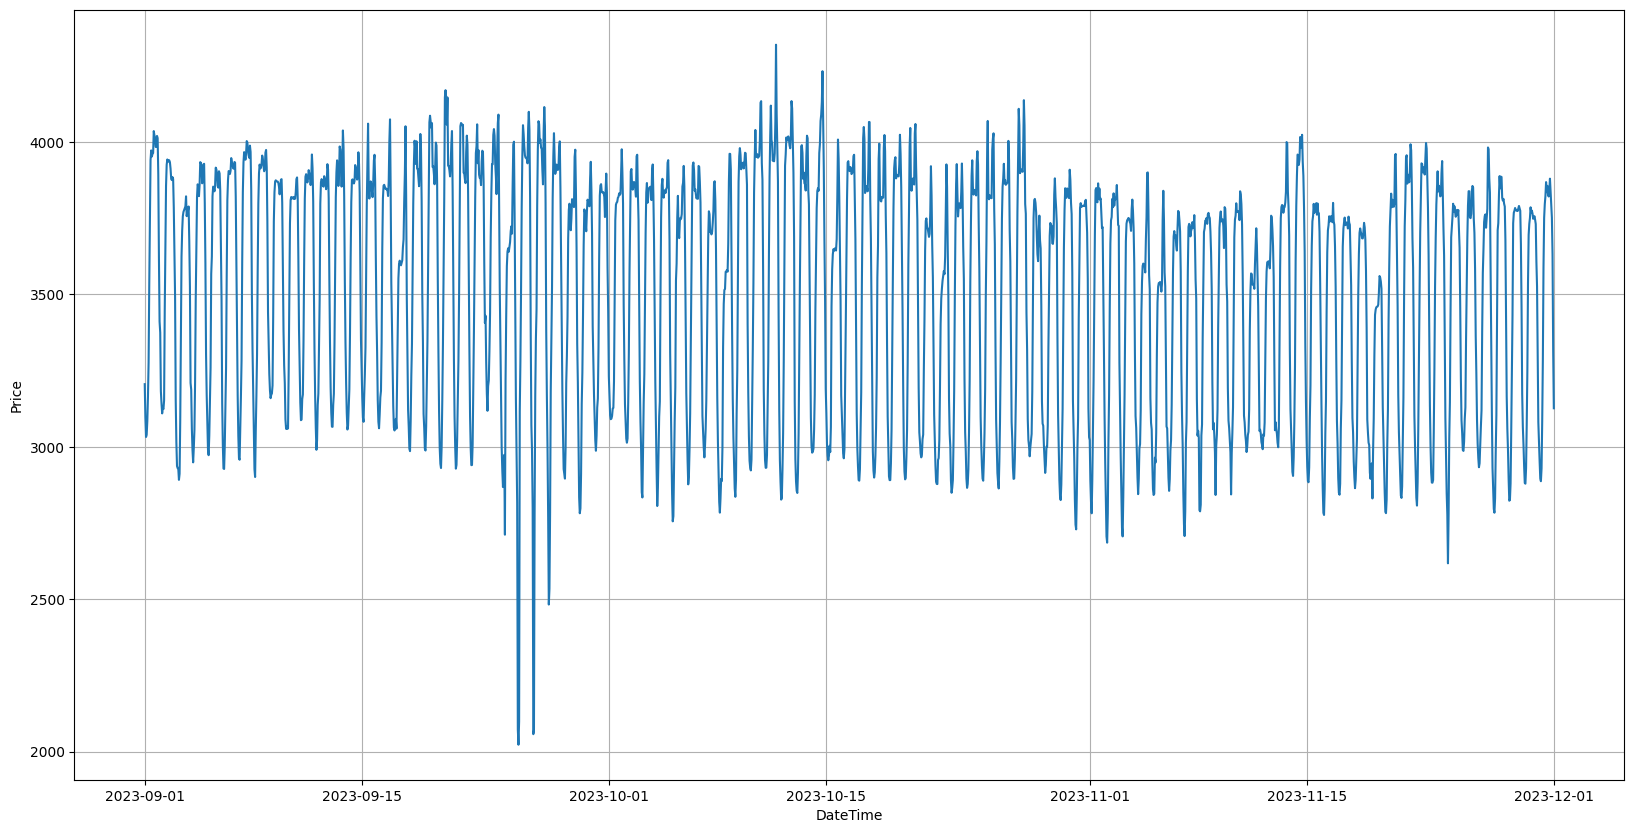

In [7]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=history_df)
plt.grid(True)

На графике наблюдаются участки с явным трендом (цена возрастает, затем снижается, снова возрастает и так далее), а также амплитуда колебаний данных периодически изменяется — то увеличивается, то уменьшается. Исходя из визуального анализа, можно сделать вывод, что данный временной ряд не является стационарным 

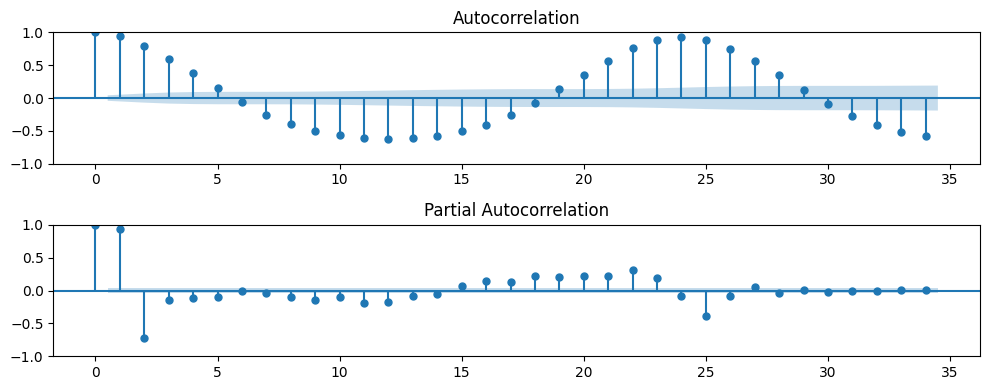

In [8]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
plot_acf(history_df, ax=ax[0])
plot_pacf(history_df, ax=ax[1])
plt.tight_layout()
plt.show()

На основе графиков автокорреляционной (ACF) и частичной автокорреляционной функций (PACF) можно сделать вывод, что временной ряд, вероятно, является стационарным. На графике ACF значения колеблются вокруг нуля без явного затухания, что характерно для стационарных рядов, в которых нет выраженного тренда или сезонной компоненты. Также, на графике PACF видно значительное значение на первом лага, после чего значения быстро приближаются к нулю, что также подтверждает зависимость текущих значений только от ближайших предыдущих наблюдений. Это типичная ситуация для стационарных временных рядов.

## Тест Дики-Фуллера

In [9]:
result = adfuller(history_df)
critical_value = result[4]['5%']
print('Критическое значение (5%):', critical_value)
print('ADF Statistic: %f' % result[0])
print('p-значение: %f' % result[1])

Критическое значение (5%): -2.8628808769203995
ADF Statistic: -4.481875
p-значение: 0.000212


Рассчитанное p-value меньше уровня значимости, следовательно мы отклоняем нулевую гипотезу о нестационарности ряда. **0-ая гипотеза**: ряд нестационарен, **p-уровень занчимости**: 0.05

## Общий вывод о стационарности ряда

В итоге, значения ADF Statistic и p-значение указывают на то, что ряд можно считать стационарным с уровнем значимости 0,05. Временной ряд прошел тесты на стационарность, такие как тесты Дики-Фуллера и графики автокорреляционной (АКФ) и частичной автокорреляционной функций (ЧАКФ) показывают поведение, характерное для стационарного ряда, то, строго говоря, ряд является стационарным. Однако, несмотря на положительные результаты теста, визуальная проверка ряда не подтвердила его стационарность, поскольку на графике продолжают прослеживаться тренды и изменяющаяся амплитуда колебаний. Поэтому было принято решение выполнить дифференцирование ряда для устранения трендов и повышения его стационарности (данная операция представлена уже в разделе "Определение параметра d ARIMA модели")

# Построение ARIMA модели

## Определение параметра d

Критическое значение (5%): -2.8628808769203995
ADF Statistic: -12.829297
p-значение: 0.000000000000000000000005920678


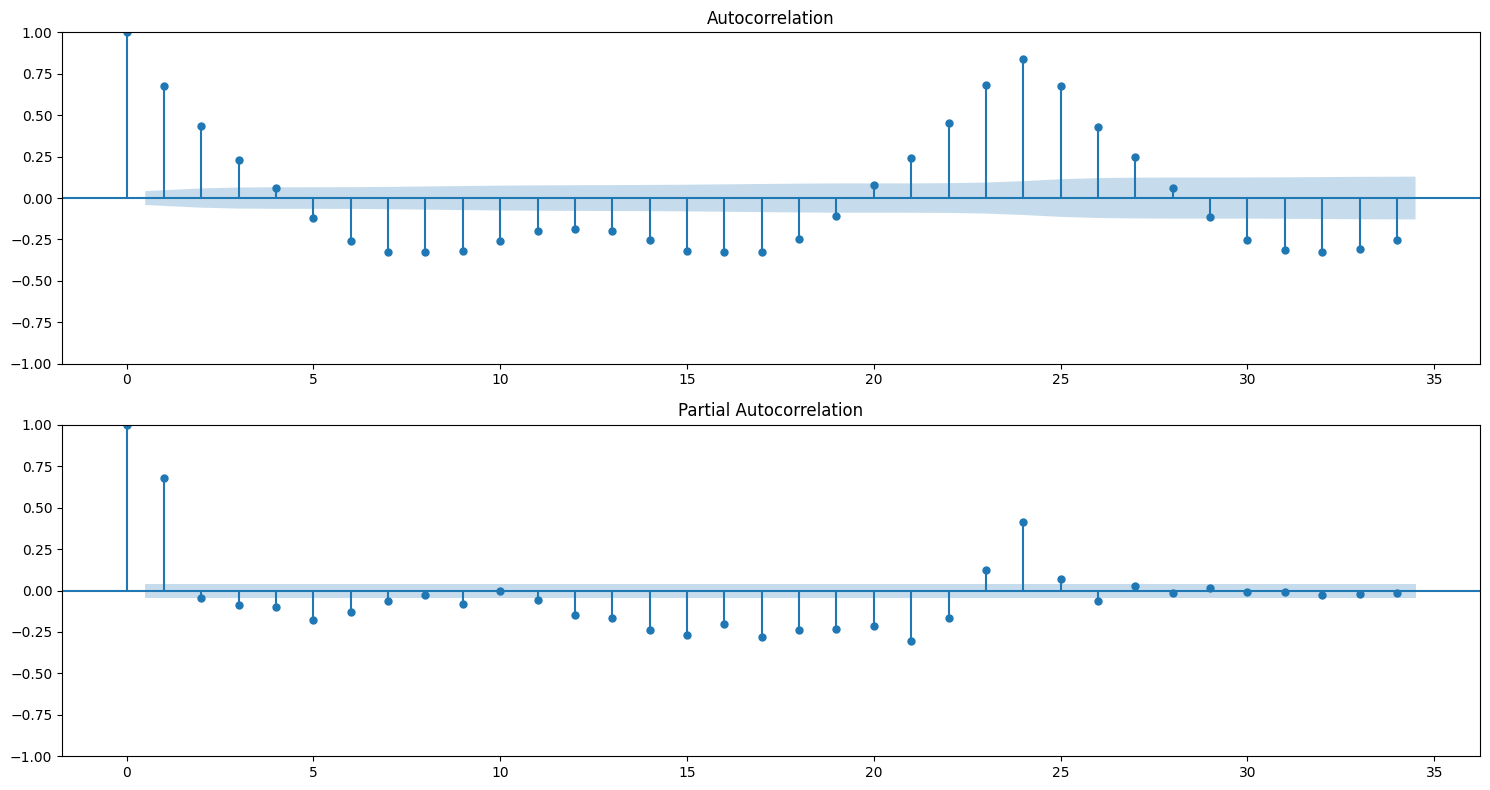

In [10]:
#диференцируем ряд и заполняем пропуск ближайшим не None значением
st_history_df = history_df.diff() # stationary_history_df
st_history_df.replace(0, np.nan, inplace=True)
st_history_df.fillna(method='bfill', inplace=True)
# Повторное тестирование на стационарность
result2 = adfuller(st_history_df)
critical_value = result[4]['5%']
print('Критическое значение (5%):', critical_value)
print('ADF Statistic: %f' % result2[0])
print('p-значение: %.30f' % result2[1])

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 2*4))
plot_acf(st_history_df, ax=ax[0])
plot_pacf(st_history_df, ax=ax[1])
plt.tight_layout()
plt.show()

Полученное p-value < 0.05 -> можем сделать вывод, что получившийся ряд стационарен -> параметр модели d следует взять равным 1

## Оценка графиков ACF и PACF

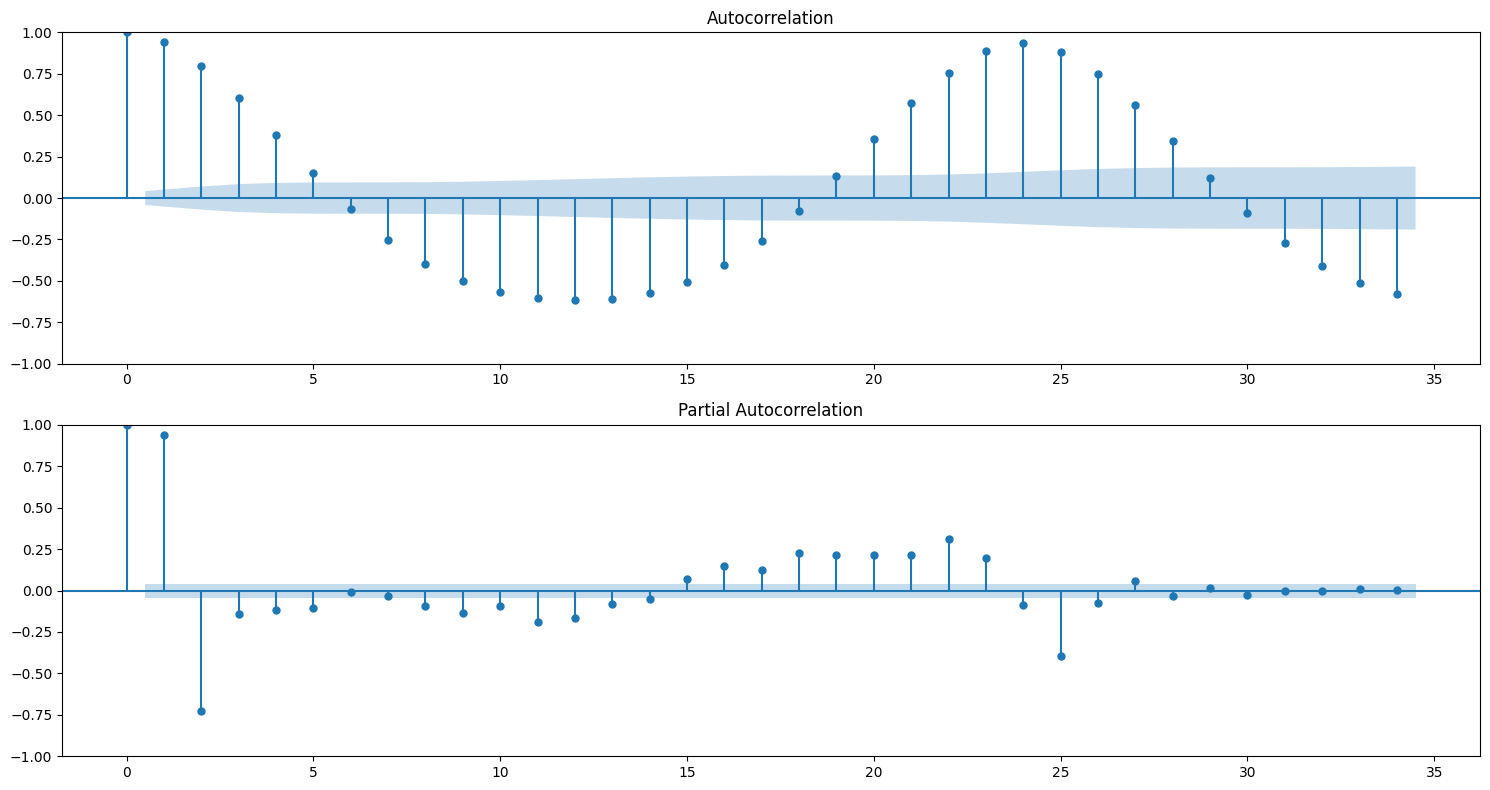

In [11]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 2*4))
plot_acf(history_df, ax=ax[0])
plot_pacf(history_df, ax=ax[1])
plt.tight_layout()
plt.show()

- В соответствии с графиком АКФ q=2

- В соответствии с граифком ЧАКФ p=3


Для выбора оптимальных параметров ARIMA-модели так же можно использовать информационный критерий Акаике (AIC), который помогает определить модель с минимальным значением статистики, указывающей на наилучшую модель среди рассматриваемых вариантов. Ниже представлена ф-ция, подбераюшая наиболее подхлдящие параметы p, d и q для ARIMA-модели

In [12]:
def my_mape(real , predict):
  return np.average(abs((real - predict )/ real))

In [13]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
def OA(time_ryad, train_size=0.8):
    # Отключение предупреждений
    warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.", category=UserWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    # Определение диапазонов для p, d, q
    p = range(1, 7)
    d = range(0, 4)
    q = range(0, 4)
    pdq = list(itertools.product(p, d, q))
    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(time_ryad) * train_size)
    train_data = time_ryad[:train_size]
    test_data = time_ryad[train_size:]
    results = []  # Инициализация списка для хранения результатов: p, d, q, AIC
    for params in pdq:  # Перебор всех комбинаций параметров
        try:
            # Создание и обучение модели ARIMA с текущими параметрами
            model_test = ARIMA(train_data, order=params)
            result_test = model_test.fit()
            # Прогноз на тестовых данных
            forecast = result_test.forecast(steps=len(test_data))
            # Сохранение параметров и AIC в список
            results.append((params[0], params[1], params[2], result_test.aic))
        except Exception as e:  # Пропуск итерации в случае ошибки
            continue
    # Создание DataFrame из результатов
    results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'AIC'])
    # Сортировка по AIC
    results_df = results_df.sort_values(by='AIC').reset_index(drop=True)
    return results_df  # Возврат таблицы с результатами
OA(history_df)

,p,d,q,AIC
0,4,1,3,20725.481464
1,4,0,2,20729.949698
2,2,1,3,20743.376675
3,5,0,3,20777.277812
4,6,0,3,20780.263691
...,...,...,...,...
91,4,3,0,21858.453966
92,3,3,0,21930.962767
93,2,3,0,22114.014346
94,1,0,0,22167.363625


В результате анализа, показанного в таблице, получилось, что оптимальными параметрами для модели ARIMA являются p=4, d=1 и q=3. Эти параметры были выбраны, поскольку они дают наименьшее значение критерия Акаике, которое равное приблизительно 20725,48. Низкое значение AIC (по сравнению с более высокими значениями AIC) указывает на то, что данная модель хорошо подходит для представления структуры временного ряда, при этом не перегружая модель избыточным количеством параметров.

## Обоснование приемлимой точности

Для построения качественного прогноза цен на электроэнергию важно задать приемлемый уровень точности модели. В данном исследовании для оценки точности прогноза будет использована такая метрика, как MAPE (средняя абсолютная процентная ошибка)

In [14]:
delta = (history_df.max() - history_df.min()) / history_df.mean()
acceptable_mape = delta / 5
print('Приемлимая mape:', acceptable_mape)

Приемлимая mape: 0.13054398335349265


Этот код вычисляет приемлемое значение MAPE (средней абсолютной процентной ошибки) на основе диапазона данных в датафрейме «history_df». Получим значение примерно равное 0,13, или 13%. Можно заключить, что для выбранного исторического ряда предельно допустимая точность модели по метрике MAPE составляет 13%. Это значение указывает на то, что средняя абсолютная ошибка прогнозов модели составляет 13% от фактических значений, и данный уровень точности является приемлемым

## Обучение моделии оценка на точности прогноза на историческом ряду

Для построения модели ARIMA(4,1,3) нужно использовать исторические данные временного ряда и библиотеку statsmodels.tsa.arima.model  с импортированной функцией ARIMA.

In [15]:
# Обучение модели ARIMA
model = ARIMA(history_df, order=(4, 1, 3))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2184
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -12871.540
Date:                Wed, 26 Feb 2025   AIC                          25759.080
Time:                        23:55:55   BIC                          25804.588
Sample:                    09-01-2023   HQIC                         25775.716
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3342      0.024     56.546      0.000       1.288       1.380
ar.L2          0.5125      0.021     23.984      0.000       0.471       0.554
ar.L3         -1.3661      0.021    -64.316      0.000      -1.408      -1.324
ar.L4          0.4450      0.022     20.410      0.000       0.402       0.488
ma.L1         -0.8997      0.018    -49.395      0.000      -0.935      -0.864
ma.L2         -0.9742      0.013    -73.658      0.000      -1.000      -0.948
ma.L3          0.8816      0.019     46.178      0.000       0.844       0.919
sigma2      9227.1565    164.011     56.259      0.000    8905.700    9548.613
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              6340.98
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Графики, с помощью которых происходит проверка на независимость и нормальность распределения остатков (графики стандартизированных остатков, гистограмма с оценкой плотности распределения остатков, Q-Q график, коррелограмма)

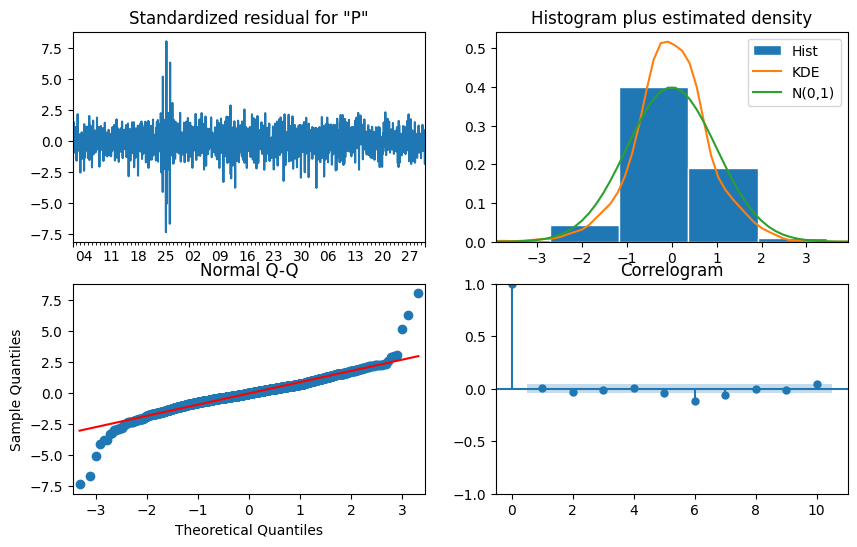

In [16]:
model_fit.plot_diagnostics(figsize=(10, 6))
plt.show()

График стандартизированных остатков (верхний левый угол) показывает случайные колебания остатков вокруг среднего значения (нулевая линия), что указывает на отсутствие явных трендов и сезонности. Это является хорошим признаком для постоянной дисперсии, так как значения колеблются вокруг нуля с более-менее одинаковой амплитудой.

Гистограмма остатков вместе с кривой плотности (верхний правый угол) показывает, что распределение остатков близко к симметрии вокруг нуля, и оно близко к нормальному. Однако есть небольшие отклонения на концах гистограммы, но в целом форма близка к нормальной. Линия N(0,1), представляющая нормальное распределение, также близка к кривой KDE.

На Q-Q графике (нижний левый угол) точки располагаются почти по прямой линии, что подтверждает нормальное распределение остатков. Однако есть небольшие отклонения на концах, но они допустимы и незначительны, так как основной массив точек лежит вдоль красной линии, что указывает на нормальное распределение.

На графике коррелограммы (ACF остатков) (нижний правый угол) все коэффициенты автокорреляции (кроме самого первого) находятся в пределах доверительного интервала, что указывает на отсутствие автокорреляции в остатках. Так же можно заключить, что остатки в данной модели независимы, так как все автокорреляции находятся в пределах доверительного интервала. Это свидетельствует о том, что модель достаточно хорошо описала структуру временного ряда, и остатки ведут себя как белый шум, то есть являются случайными и не зависят друг от друга.

На коррелограмме автокорреляции остатки не имеют значимых корреляций (все значения остаются в пределах доверительных интервалов), что подтверждает их независимость.

Следовательно, по гистограмме, Q-Q графику и коррелограмме видно, что остатки распределены примерно нормально. График стандартизированных остатков показывает, что дисперсия остатков стабильна. Временной ряд проходит проверку на нормальность распределения остатков и независимость

In [ ]:
# Построение прогнозируемых значений на историческом интервале
forecast_values = model_fit.predict(start=history_df.index[0], end=history_df.index[-1],  dynamic=False)
forecast_values.replace(0, np.nan, inplace=True)
forecast_values.fillna(method='bfill', inplace=True)
forecast_values

2023-09-01 00:00:00    3252.969833
2023-09-01 01:00:00    3252.969833
2023-09-01 02:00:00    3022.953490
2023-09-01 03:00:00    2985.050227
2023-09-01 04:00:00    3048.783159
                          ...     
2023-11-30 19:00:00    3742.165785
2023-11-30 20:00:00    3686.593972
2023-11-30 21:00:00    3660.183077
2023-11-30 22:00:00    3489.872094
2023-11-30 23:00:00    3115.099028
Freq: h, Name: predicted_mean, Length: 2184, dtype: float64

Исторический ряд необходимо проверить на MAPE, удовлетворяют ли прогнозные значения приемлемой точности

In [18]:
def mape(real , predict):
  return np.average(abs((real - predict )/ real))

mape_of_df = abs(mape(history_df.values,forecast_values.values))
if mape_of_df < acceptable_mape:
  print(f'mape={mape_of_df}. Удовлетворительная точность')
else:
  print(f'mape={mape_of_df}. Не удовлетворительная точность')

mape=0.01819434561372451. Удовлетворительная точность


В выводе указано, что MAPE = 1,819%, что меньше порога приемлемой MAPE 13,05%. Это указывает на хорошую точность модели, так как процент ошибки меньшн (1,819% < 13,05%), и выводится сообщение об удовлетворительной точности

Дальше нужно визуально сравнить фактические и спрогнозированные значения на историческом ряду. Строим график с фактическими и спрогнозированными данными 

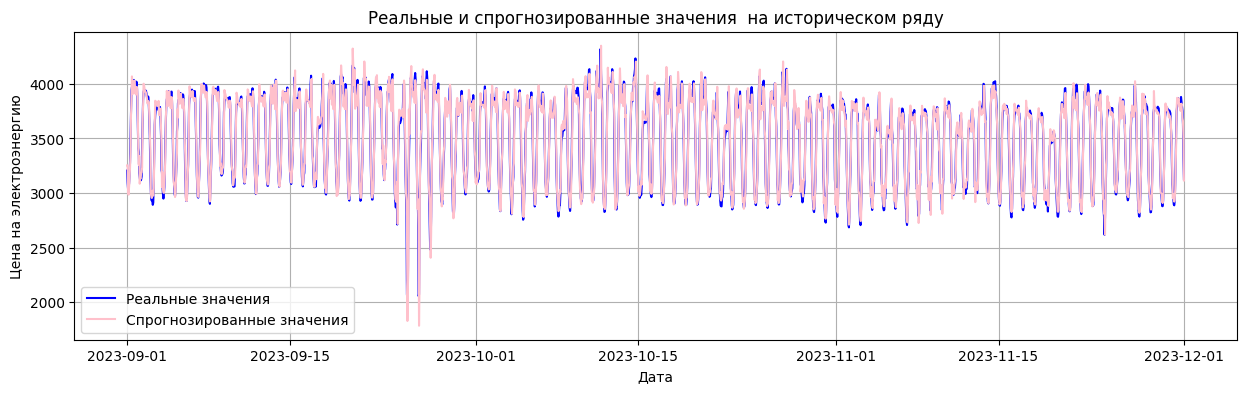

In [19]:
plt.figure(figsize=(15,4))
plt.plot(history_df.index, history_df, label='Реальные значения', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='pink')
plt.title('Реальные и cпрогнозированные значения  на историческом ряду')
plt.xlabel('Дата')
plt.ylabel('Цена на электроэнергию')
plt.legend()
plt.grid(True)
plt.show()

## Построение прогноза на будущее

In [ ]:
# Спрогнозированные значения ВР (с 1 дек. 0:00 до 2 дек. 23:00)
future_forecast = model_fit.forecast(steps=48)
future_forecast

2023-12-01 00:00:00    2993.760001
2023-12-01 01:00:00    2933.210799
2023-12-01 02:00:00    2910.769843
2023-12-01 03:00:00    2947.324992
2023-12-01 04:00:00    3008.262705
2023-12-01 05:00:00    3112.014717
2023-12-01 06:00:00    3221.751430
2023-12-01 07:00:00    3354.359000
2023-12-01 08:00:00    3472.911123
2023-12-01 09:00:00    3595.307198
2023-12-01 10:00:00    3687.048533
2023-12-01 11:00:00    3769.237162
2023-12-01 12:00:00    3811.464390
2023-12-01 13:00:00    3839.065172
2023-12-01 14:00:00    3826.079827
2023-12-01 15:00:00    3801.786549
2023-12-01 16:00:00    3743.804444
2023-12-01 17:00:00    3684.013432
2023-12-01 18:00:00    3601.931002
2023-12-01 19:00:00    3530.169113
2023-12-01 20:00:00    3448.233231
2023-12-01 21:00:00    3387.658820
2023-12-01 22:00:00    3326.353622
2023-12-01 23:00:00    3293.511840
2023-12-02 00:00:00    3264.563820
2023-12-02 01:00:00    3265.902048
2023-12-02 02:00:00    3270.436457
2023-12-02 03:00:00    3302.103336
2023-12-02 04:00:00 

Вычисление MAPE для значений, которые получились в результате прогноза:

In [21]:
def mape_ff(real , predict):
  return np.average(abs((real - predict )/ real))

mape_of_df = abs(mape_ff(forecast_df.to_numpy(), future_forecast.to_numpy()))
if mape_of_df < acceptable_mape:
  print(f'mape={mape_of_df}. Удовлетворительная точность')
else:
  print(f'mape={mape_of_df}. Не удовлетворительная точность')

mape=0.04862151031723263. Удовлетворительная точность


Полученное значение MAPE (средняя абсолютная процентная ошибка) составляет примерно 4.86%. Это указывает на то, что средняя ошибка прогноза составляет менее 4.86% от фактических значений, что является хорошим результатом для прогноза временного ряда

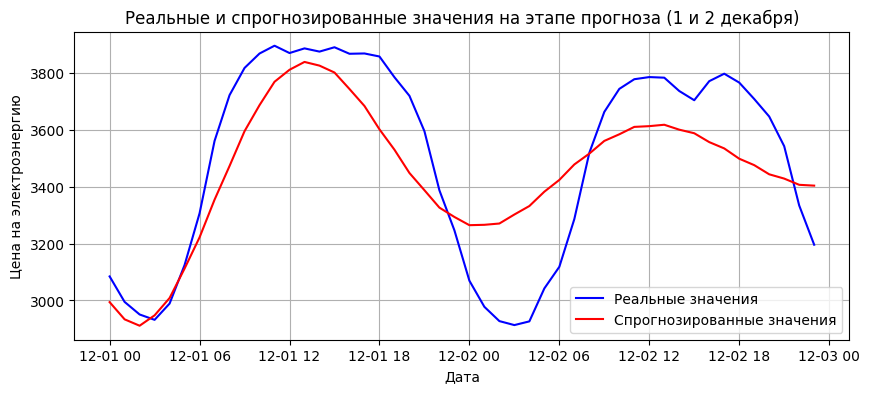

In [22]:
plt.figure(figsize=(10,4))
plt.plot(forecast_df.index, forecast_df, label='Реальные значения', color='blue')
plt.plot(forecast_df.index, future_forecast, label='Спрогнозированные значения', color='red')
plt.title('Реальные и cпрогнозированные значения на этапе прогноза (1 и 2 декабря)')
plt.xlabel('Дата')
plt.ylabel('Цена на электроэнергию')
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим рисунок выше. На графике представлены реальные и спрогнозированные значения цен на электроэнергию за период с 1 по 2 декабря 2023 года. Реальные значения демонстрируют выраженные колебания, включая подъемы и спады в течение дня. При этом спрогнозированные значения отличаются более сглаженным характером, отражая общую тенденцию изменения цен, но не всегда точно повторяя все изменения цен. Это свидетельствует о том, что модель хорошо улавливает основные тренды изменения цен, однако её точность может снижаться при попытках воспроизвести быстрые и значительные изменения, связанные с внешними факторами

График ниже показывает построенные спрогнозированные значения в масштабе всего временного ряда

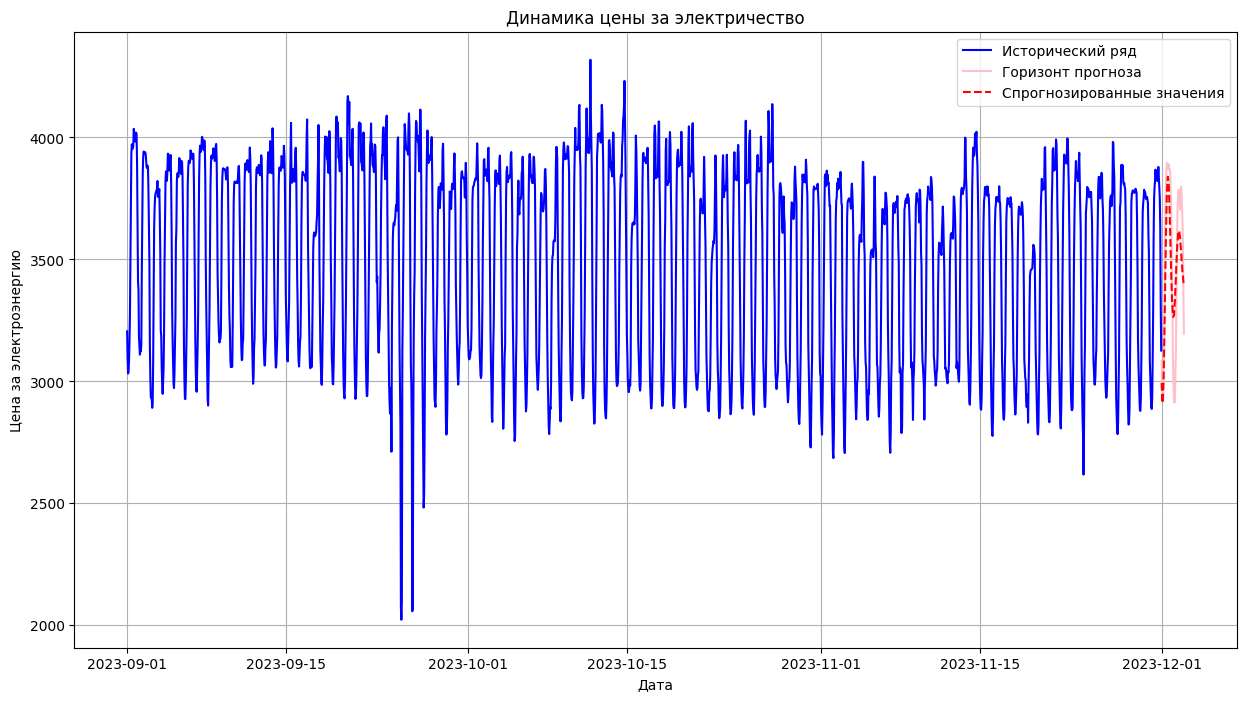

In [23]:
plt.figure(figsize=(15,8))

plt.plot(history_df.index, history_df, label='Исторический ряд', color='blue')
plt.plot(forecast_df.index, forecast_df, label='Горизонт прогноза', color='pink')
plt.plot(forecast_df.index, future_forecast, label='Спрогнозированные значения', color='red', linestyle='--')

plt.title('Динамика цены за электричество')
plt.xlabel('Дата')
plt.ylabel('Цена за электроэнергию')
plt.legend()

plt.grid(True)
plt.show()

- https://timeweb.cloud/tutorials/python/prognozirovanie-vremennyh-ryadov-python-3
- https://habr.com/ru/companies/mvideo/articles/769756
- https://habr.com/ru/companies/mvideo/articles/769190/
- https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf#Autocorrelation-Function-and-Partial-Autocorrelation-Function
- https://scikit-learn.org/ - документация к библиотеке
- https://www.statsmodels.org/ - документация к библиотеке

Ниже представлен график, где цветами разделяются исторический ряд и горизонт прогноза

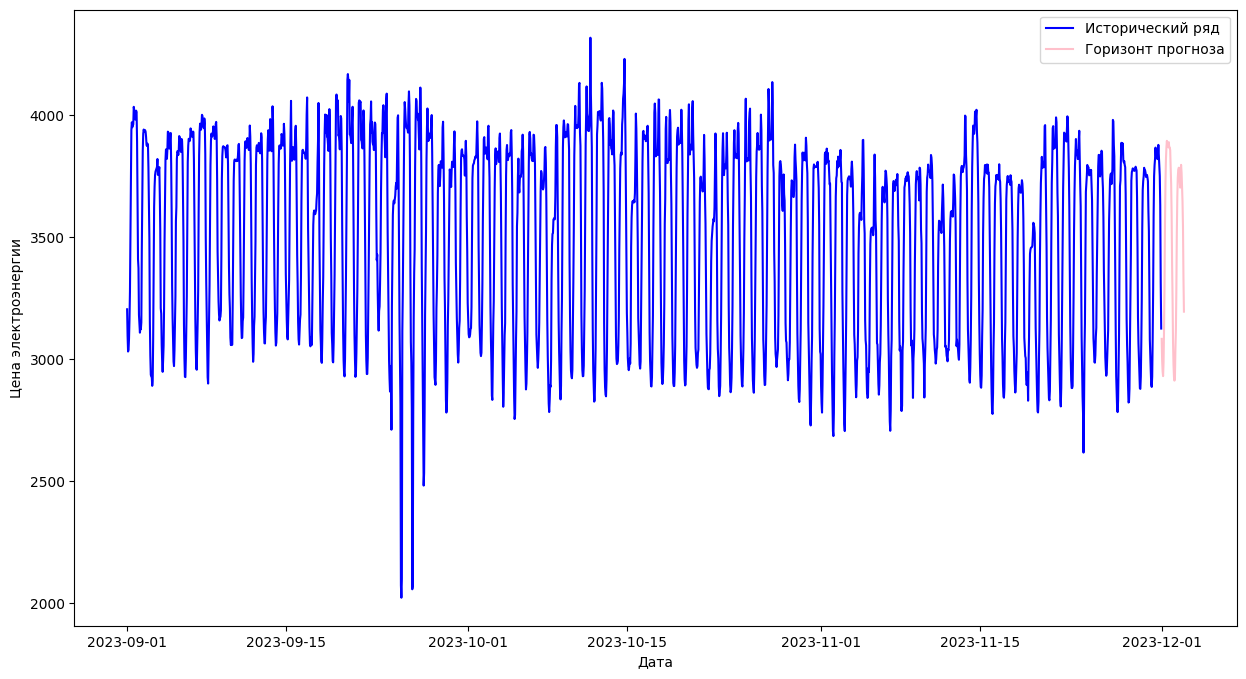

In [24]:
# Делим график на "историческую" часть и на горизонт прогноза
plt.figure(figsize=(15,8))

plt.plot(history_df.index, history_df, label='Исторический ряд', color='blue')
plt.plot(forecast_df.index, forecast_df, label='Горизонт прогноза', color='pink')

plt.xlabel('Дата')
plt.ylabel('Цена электроэнергии')
plt.legend()

plt.grid(False)
plt.show()